# **re:Mars - Anomaly detection workshop** - From deep space to shop floor
**Leveraging Amazon Lookout for Equipment** | *Part 1 - Data preparation*

# **Initialization**
---

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade tqdm lookoutequipment

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Imports

In [3]:
import boto3
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker
import shutil
import sys
import zipfile

from botocore.client import ClientError
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

# SDK / toolbox for managing Lookout for Equipment API calls:
import lookoutequipment as lookout

### Parameters
Let's first check if the bucket name is defined, if it exists and if we have access to it from this notebook. If this notebook does not have access to the S3 bucket, you will have to update its permission:

In [6]:
BUCKET           = sagemaker.Session().default_bucket()
PREFIX_TRAINING  = config.PREFIX_TRAINING
PREFIX_LABEL     = config.PREFIX_LABEL
DATASET_NAME     = config.DATASET_NAME
MODEL_NAME       = config.MODEL_NAME
EQUIPMENT        = config.EQUIPMENT

ROLE_ARN         = sagemaker.get_execution_role()
RAW_DATA         = os.path.join('..', 'dataset')
TMP_DATA         = os.path.join('..', 'data', 'interim')
PROCESSED_DATA   = os.path.join('..', 'data', 'processed')
LABEL_DATA       = os.path.join(PROCESSED_DATA, 'label-data')
TRAIN_DATA       = os.path.join(PROCESSED_DATA, 'training-data')
INFERENCE_DATA   = os.path.join(PROCESSED_DATA, 'inference-data')

os.makedirs(TMP_DATA,         exist_ok=True)
os.makedirs(RAW_DATA,         exist_ok=True)
os.makedirs(PROCESSED_DATA,   exist_ok=True)
os.makedirs(LABEL_DATA,       exist_ok=True)
os.makedirs(TRAIN_DATA,       exist_ok=True)
os.makedirs(INFERENCE_DATA,   exist_ok=True)

# AWS Look & Feel definition for Matplotlib
plt.style.use('../utils/aws_matplotlib_template.py')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

%matplotlib inline
BUCKET

# **Dataset overview**
---

### **Loading dataset**

In [7]:
ARCHIVE_PATH = os.path.join(RAW_DATA, 'sensors.zip')
DEST_PATH    = os.path.join(TMP_DATA, 'sensors.csv')
DEST_DIR     = os.path.dirname(DEST_PATH)

print("Extracting data archive")
zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
zip_ref.extractall(DEST_DIR + '/')
zip_ref.close()

print("Loading known labels")
_ = shutil.copy(src=os.path.join(RAW_DATA, 'status.csv'), dst=os.path.join(TMP_DATA, 'status.csv'))

Extracting data archive
Loading known labels


In [8]:
pump_df = pd.read_csv(DEST_PATH)
pump_df['Timestamp'] = pd.to_datetime(pump_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
pump_df = pump_df.set_index('Timestamp')

status_df = pd.read_csv(os.path.join(TMP_DATA, 'status.csv'))
status_df['Timestamp'] = pd.to_datetime(status_df['Timestamp'])
status_df = status_df.set_index('Timestamp')

pump_df['machine_status'] = status_df['machine_status']
del status_df

pump_df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NaN
2018-04-01 00:05:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NaN
2018-04-01 00:10:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NaN
2018-04-01 00:15:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NaN
2018-04-01 00:20:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NaN


### **Dataset visualization**

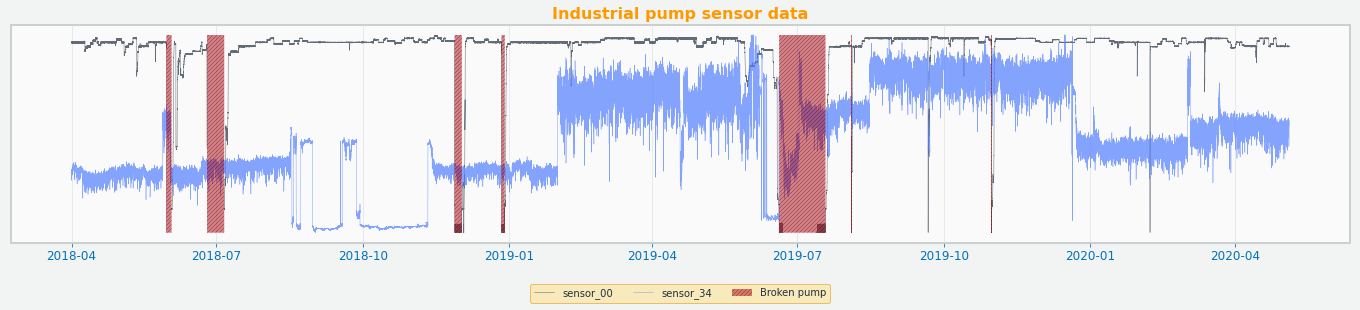

In [10]:
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.5

fig = plt.figure(figsize=(24,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_yticks([])
plot1 = ax1.plot(pump_df['sensor_00'], label='sensor_00', alpha=0.7)
ax1 = ax1.twinx()
ax1.grid(False)
ax1.set_yticks([])
plot2 = ax1.plot(pump_df['sensor_34'], label='sensor_34', color=colors[1], alpha=0.7)

ax2 = ax1.twinx()
plot3 = ax2.fill_between(
    x=pump_df.index, y1=0.0, y2=pump_df['machine_status'], 
    color=colors[5], linewidth=0.0, edgecolor='#000000', alpha=0.5, hatch="//////", 
    label='Broken pump'
)
ax2.grid(False)
ax2.set_yticks([])

labels = [plot1[0].get_label(), plot2[0].get_label(), plot3.get_label()]
plt.legend(handles=[plot1[0], plot2[0], plot3], labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -.3))
plt.title('Industrial pump sensor data')
plt.show()

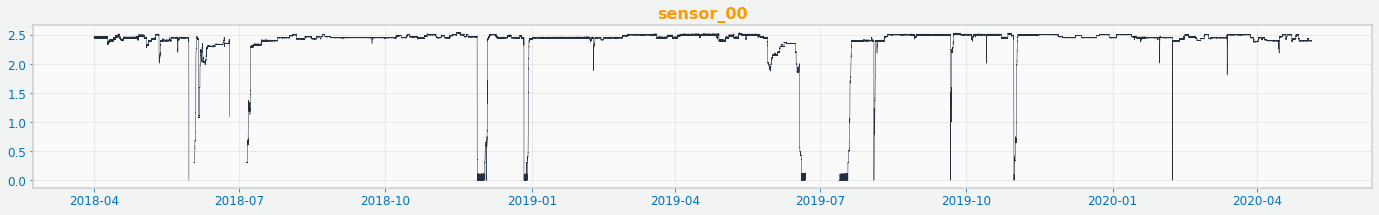

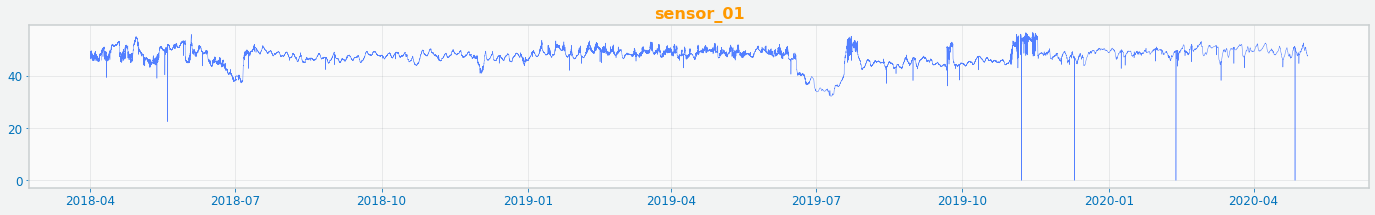

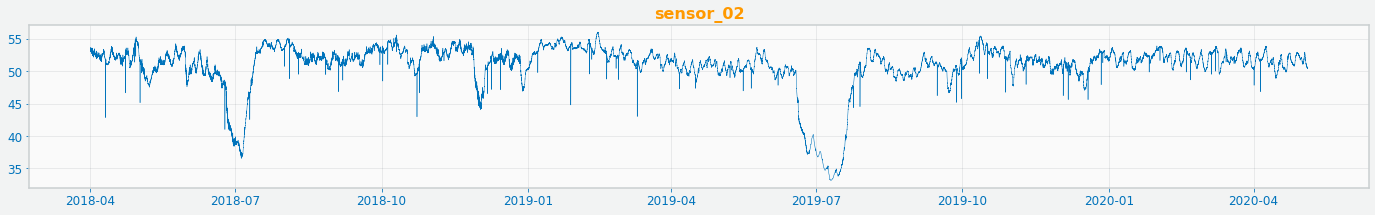

In [11]:
for index, f in enumerate(list(pump_df.columns)[:3]):
    fig = plt.figure(figsize=(24,3))
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(pump_df[f], color=colors[index % len(colors)])
    ax1.set_title(f)
    
plt.show()

### **Preparing time series data**

In [12]:
features = list(pump_df.columns)[:-1]

for tag in tqdm(features):
    os.makedirs(os.path.join(TRAIN_DATA, EQUIPMENT, tag), exist_ok=True)
    fname = os.path.join(TRAIN_DATA, EQUIPMENT, tag, 'tag_data.csv')
    tag_df = pump_df[[tag]]
    tag_df.to_csv(fname)

100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


### **Uploading data to Amazon S3**
Let's now load our training data and labels to Amazon S3, so that Lookout for Equipment can access them to train and evaluate a model.

In [14]:
train_s3_path = f's3://{BUCKET}/{PREFIX_TRAINING}{EQUIPMENT}/'
!aws s3 cp --recursive $TRAIN_DATA/water-pump $train_s3_path

upload: ../data/processed/training-data/water-pump/sensor_07/tag_data.csv to s3://sagemaker-eu-west-1-038552646228/training-data/water-pump/sensor_07/tag_data.csv
upload: ../data/processed/training-data/water-pump/sensor_02/tag_data.csv to s3://sagemaker-eu-west-1-038552646228/training-data/water-pump/sensor_02/tag_data.csv
upload: ../data/processed/training-data/water-pump/sensor_08/tag_data.csv to s3://sagemaker-eu-west-1-038552646228/training-data/water-pump/sensor_08/tag_data.csv
upload: ../data/processed/training-data/water-pump/sensor_04/tag_data.csv to s3://sagemaker-eu-west-1-038552646228/training-data/water-pump/sensor_04/tag_data.csv
upload: ../data/processed/training-data/water-pump/sensor_05/tag_data.csv to s3://sagemaker-eu-west-1-038552646228/training-data/water-pump/sensor_05/tag_data.csv
upload: ../data/processed/training-data/water-pump/sensor_06/tag_data.csv to s3://sagemaker-eu-west-1-038552646228/training-data/water-pump/sensor_06/tag_data.csv
upload: ../data/proces

In [16]:
training_start   = np.min(pump_df.index)
evaluation_end   = np.max(pump_df.index)
evaluation_start = evaluation_end + relativedelta(months=-6)
training_end     = evaluation_start + relativedelta(minutes=-1)

print('Training   |', training_start, training_end)
print('Evaluation |', evaluation_start, evaluation_end)

Training   | 2018-04-01 00:00:00 2019-11-04 23:54:00
Evaluation | 2019-11-04 23:55:00 2020-05-04 23:55:00


# **Data ingestion**
---

Let's double check the values of all the parameters that will be used to ingest some data into an existing Lookout for Equipment dataset:

In [17]:
ROLE_ARN, BUCKET, PREFIX_TRAINING + EQUIPMENT + '/', DATASET_NAME

('arn:aws:iam::038552646228:role/service-role/AmazonSageMaker-ExecutionRole-20210903T075832',
 'sagemaker-eu-west-1-038552646228',
 'training-data/water-pump/',
 'water-pump')

In [35]:
lookout_dataset = lookout.LookoutEquipmentDataset(
    dataset_name=DATASET_NAME,
    component_root_dir=f'{TRAIN_DATA}/{EQUIPMENT}',
    access_role_arn=ROLE_ARN
)
lookout_dataset.create()
response = lookout_dataset.ingest_data(BUCKET, PREFIX_TRAINING + EQUIPMENT + '/')

Dataset "water-pump" already exists and can be used to ingest data or train a model.


We use the following cell to monitor the ingestion process. This process should take between **10 and 15 minutes** given the amount of data we have to ingest (~350 MB). During ingestion, Lookout for Equipment will prepare the data so that it can be processed by multiple algorithms (deep learning, statistical and traditional machine learning ones). It will also grade them to issue a data quality report:

In [36]:
lookout_dataset.poll_data_ingestion(sleep_time=60)

2022-06-14 12:08:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:09:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:10:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:11:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:12:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:13:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:14:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:15:34 | Data ingestion: IN_PROGRESS
2022-06-14 12:16:35 | Data ingestion: IN_PROGRESS
2022-06-14 12:17:35 | Data ingestion: IN_PROGRESS
2022-06-14 12:18:35 | Data ingestion: IN_PROGRESS
2022-06-14 12:19:35 | Data ingestion: SUCCESS


We created a **Lookout for Equipment dataset** and ingested the S3 data previously uploaded into this dataset. **Let's now train a model based on these data.**

# **Model training**
---

In [37]:
# Configuring time ranges:
training_start   = pd.to_datetime('2018-04-01 00:00:00')
training_end     = pd.to_datetime('2018-10-31 23:59:00')
evaluation_start = pd.to_datetime('2018-11-01 00:00:00')
evaluation_end   = pd.to_datetime('2020-04-30 23:59:00')

print(f'  Training period | from {training_start} to {training_end}')
print(f'Evaluation period | from {evaluation_start} to {evaluation_end}')

print(training_end - training_start)
print(evaluation_end - evaluation_start)

  Training period | from 2018-04-01 00:00:00 to 2018-10-31 23:59:00
Evaluation period | from 2018-11-01 00:00:00 to 2020-04-30 23:59:00
213 days 23:59:00
546 days 23:59:00


In [39]:
lookout_model = lookout.LookoutEquipmentModel(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
lookout_model.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
lookout_model.set_target_sampling_rate(sampling_rate='PT5M')
lookout_model.train()

The following method encapsulate a call to the [**DescribeModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DescribeModel.html) API and collect the model progress by looking at the `Status` field retrieved from this call. This training should take around 25-30 minutes to run:

In [42]:
lookout_model.poll_model_training(sleep_time=60)

2022-06-14 12:26:46 | Model training: IN_PROGRESS
2022-06-14 12:27:46 | Model training: IN_PROGRESS
2022-06-14 12:28:46 | Model training: IN_PROGRESS
2022-06-14 12:29:46 | Model training: IN_PROGRESS
2022-06-14 12:30:46 | Model training: IN_PROGRESS
2022-06-14 12:31:46 | Model training: IN_PROGRESS
2022-06-14 12:32:46 | Model training: IN_PROGRESS
2022-06-14 12:33:46 | Model training: IN_PROGRESS
2022-06-14 12:34:46 | Model training: IN_PROGRESS
2022-06-14 12:35:47 | Model training: IN_PROGRESS
2022-06-14 12:36:47 | Model training: IN_PROGRESS
2022-06-14 12:37:47 | Model training: IN_PROGRESS
2022-06-14 12:38:47 | Model training: IN_PROGRESS
2022-06-14 12:39:47 | Model training: IN_PROGRESS
2022-06-14 12:40:47 | Model training: IN_PROGRESS
2022-06-14 12:41:48 | Model training: IN_PROGRESS
2022-06-14 12:42:48 | Model training: IN_PROGRESS
2022-06-14 12:43:48 | Model training: IN_PROGRESS
2022-06-14 12:44:48 | Model training: IN_PROGRESS
2022-06-14 12:45:48 | Model training: IN_PROGRESS


In this section, we use the dataset created earlier and trained an Amazon Lookout for Equipment model.

From here, we will **extract the evaluation data** for this model and use it to perform further analysis on the model results.

# **Model evaluation**
---

After the model is trained, we can extract the backtesting results and visualize the anomalies detected by Lookout for Equipment over the evaluation period. Although evaluating your model is optional (you don't need to do this to deploy and use the model), this section will give you some pointers on how to post-process and visualize the data provided by Amazon Lookout for Equipment:

In [44]:
LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=pump_df)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()

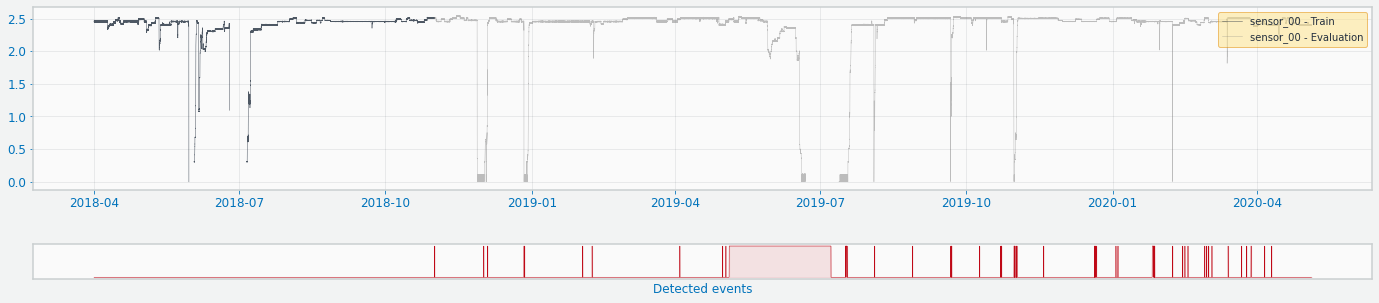

In [52]:
tags_list = list(pump_df.columns)[:-1]
custom_colors = {'labels': colors[9], 'predictions': colors[5]}
    
TSViz = lookout.plot.TimeSeriesVisualization(
    timeseries_df=pump_df,
    data_format='tabular'
)
TSViz.add_signal([tags_list[0]])
TSViz.add_predictions([predicted_ranges])
TSViz.add_train_test_split(evaluation_start)
fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)

# **Helper functions**
---

In [62]:
def plot_detected_events(group_id, start, end, signal):
    custom_colors = {
        'labels': colors[9],
        'predictions': colors[5]
    }
    
    TSViz = lookout.plot.TimeSeriesVisualization(
        timeseries_df=pump_df.loc[start:end, :],
        data_format='tabular'
    )
    TSViz.add_signal([signal])
    TSViz.add_predictions([predicted_ranges])
    TSViz.legend_format = {
        'loc': 'upper right',
        'framealpha': 0.4,
        'ncol': 3
    }
    fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)

    for ax in axis:
        ax.set_xlim((start, end))

#     fig.savefig(os.path.join('pictures-v2', f'{group_id}_detected_events.png'), pad_inches=0.05, bbox_inches='tight', facecolor='#FFFFFF')

In [63]:
def plot_signal_importance_evolution(group_id, plot_start, plot_end, signal):
    fig = plt.figure(figsize=(24,10))
    gs = GridSpec(nrows=4, ncols=1, height_ratios=[0.5, 0.3, 0.1, 0.6])
    df = expanded_results_v3.loc[plot_start:plot_end, :].copy()

    ax0 = fig.add_subplot(gs[0])
    ax0.plot(pump_df.loc[plot_start:plot_end, signal], color=colors[9], linewidth=1.0, label=signal)
    ax0.legend(loc='upper right', fontsize=12)
    ax0.set_xlim((plot_start, evaluation_end))

    ax1 = fig.add_subplot(gs[1])
    ax1.plot(predictions_df.rolling(60*24).sum(), label='Number of daily\nevent detected')
    ax1.legend(loc='upper left', fontsize=12)
    ax1.set_xlim((plot_start, evaluation_end))

    ax3 = fig.add_subplot(gs[2])
    plot_ranges(predictions_df, 'Detected events', colors[5], ax3)
    ax3.set_xlim((plot_start, evaluation_end))

    bar_width = 1.0
    num_top_signals = 5
    ax4 = fig.add_subplot(gs[3])
    bottom_values = np.zeros((len(df.index),))
    current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)
    for tag in current_tags_list:
        plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
        bottom_values += df[tag].values

    all_other_tags = [t for t in df.columns if t not in current_tags_list]
    all_other_tags_contrib = df[all_other_tags].sum(axis='columns')
    plt.bar(x=df.index, height=all_other_tags_contrib, bottom=bottom_values, alpha=0.8, width=bar_width, label=f'All the others\n({len(all_other_tags)} signals)', color='#CCCCCC')

    ax4.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.40))
    ax4.set_xlabel('Signal importance evolution', fontsize=12)
    ax4.set_xlim((plot_start, evaluation_end))

    plt.show()

#     fig.savefig(os.path.join('pictures-v2', f'{group_id}_signal_importance.png'), pad_inches=0.05, bbox_inches='tight', facecolor='#FFFFFF')
    
    return current_tags_list

In [64]:
def plot_top_signals_time_series(group_id, plot_start, plot_end, top_tags_list):
    fig = plt.figure(figsize=(24,6 * len(top_tags_list)))
    gs = GridSpec(nrows=2 * len(top_tags_list), ncols=1, height_ratios=[1.0, 0.2] *len(top_tags_list))

    for index, signal in enumerate(top_tags_list):
        ax = fig.add_subplot(gs[index*2])
        ax.plot(pump_df.loc[plot_start:plot_end, signal], color=colors[index * 2], linewidth=1.0)
        ax.set_title(f'Signal: {signal}')

        ax = fig.add_subplot(gs[index*2 + 1])
        plot_ranges(predictions_df, '', colors[5], ax)
        ax.set_xlim((plot_start, plot_end))

    plt.show()

#     fig.savefig(os.path.join('pictures-v2', f'{group_id}_top_signals.png'), pad_inches=0.05, bbox_inches='tight', facecolor='#FFFFFF')

In [59]:
def plot_histograms(group_id):
    fig = TSViz.plot_histograms(freq='60min', fig_width=24, start=training_start, end=evaluation_end, top_n=4)
#     fig.savefig(os.path.join('pictures-v2', f'{group_id}_histograms.png'), pad_inches=0.05, bbox_inches='tight', dpi=150, facecolor='#FFFFFF')

In [60]:
def plot_ranges(range_df, range_title, color, ax):
    ax.plot(range_df['Label'], color=color)
    ax.fill_between(range_df.index, 
                    y1=range_df['Label'], 
                    y2=0, 
                    alpha=0.1, 
                    color=color)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel(range_title, fontsize=12)

# **Extracting additional insights**
---
Further post-processing Lookout for Equipment outputs.

In [47]:
predicted_ranges['duration'] = pd.to_datetime(predicted_ranges['end']) - pd.to_datetime(predicted_ranges['start'])
predicted_ranges['duration'] = predicted_ranges['duration'].dt.total_seconds() / 3600
predictions_df = TSViz._convert_ranges(predicted_ranges, default_freq='1min')

In [48]:
predicted_ranges

,start,end,diagnostics,duration
0,2018-11-01 00:05:00,2018-11-01 00:50:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.00...",0.750000
1,2018-12-01 20:45:00,2018-12-01 21:00:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.17...",0.250000
2,2018-12-04 01:40:00,2018-12-04 05:45:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.05...",4.083333
3,2018-12-27 01:35:00,2018-12-27 05:00:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.01...",3.416667
4,2018-12-27 08:40:00,2018-12-27 10:15:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.02...",1.583333
...,...,...,...,...
62,2020-03-21 21:00:00,2020-03-21 21:25:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.01...",0.416667
63,2020-03-25 04:25:00,2020-03-25 04:25:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.01...",0.000000
64,2020-03-27 21:25:00,2020-03-28 02:40:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.00...",5.250000
65,2020-04-05 09:35:00,2020-04-05 10:30:00,"[{'name': 'sensor_43\sensor_43', 'value': 0.07...",0.916667


In [53]:
expanded_results = []
for index, row in predicted_ranges.iterrows():
    new_row = dict()
    new_row.update({'start': row['start']})
    new_row.update({'end': row['end']})
    new_row.update({'prediction': 1.0})
    
    diagnostics = pd.DataFrame(row['diagnostics'])
    diagnostics = dict(zip(diagnostics['name'], diagnostics['value']))
    new_row = {**new_row, **diagnostics}
        
    expanded_results.append(new_row)
    
expanded_results = pd.DataFrame(expanded_results)

df_list = []
for index, row in expanded_results.iterrows():
    new_index = pd.date_range(start=row['start'], end=row['end'], freq='5T')
    new_df = pd.DataFrame(index=new_index)
    
    for tag in tags_list:
        new_df[tag] = row[f'{tag}\\{tag}']
        
    df_list.append(new_df)
    
expanded_results_v2 = pd.concat(df_list, axis='index')
expanded_results_v2 = expanded_results_v2.reindex(predictions_df.index)

freq = '1D'
expanded_results_v3 = expanded_results_v2.resample(freq).mean()
expanded_results_v3 = expanded_results_v3.replace(to_replace=np.nan, value=0.0)

In [18]:
expanded_results_v3

NameError: name 'expanded_results_v3' is not defined

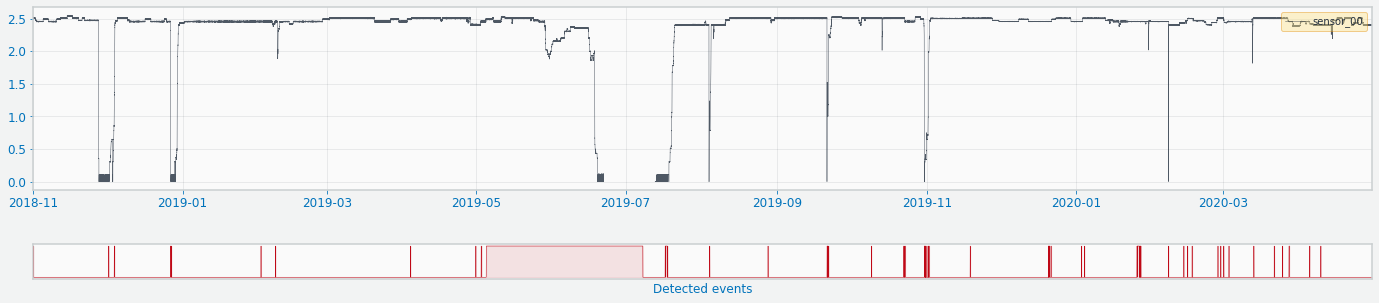

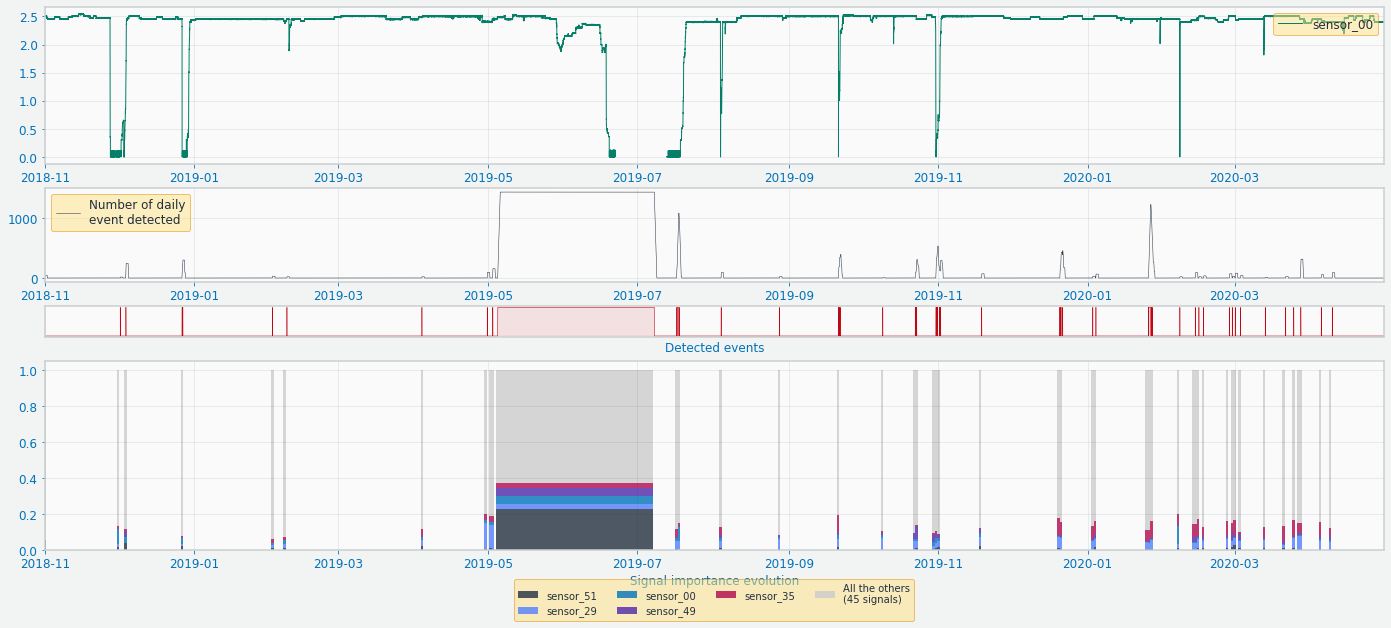

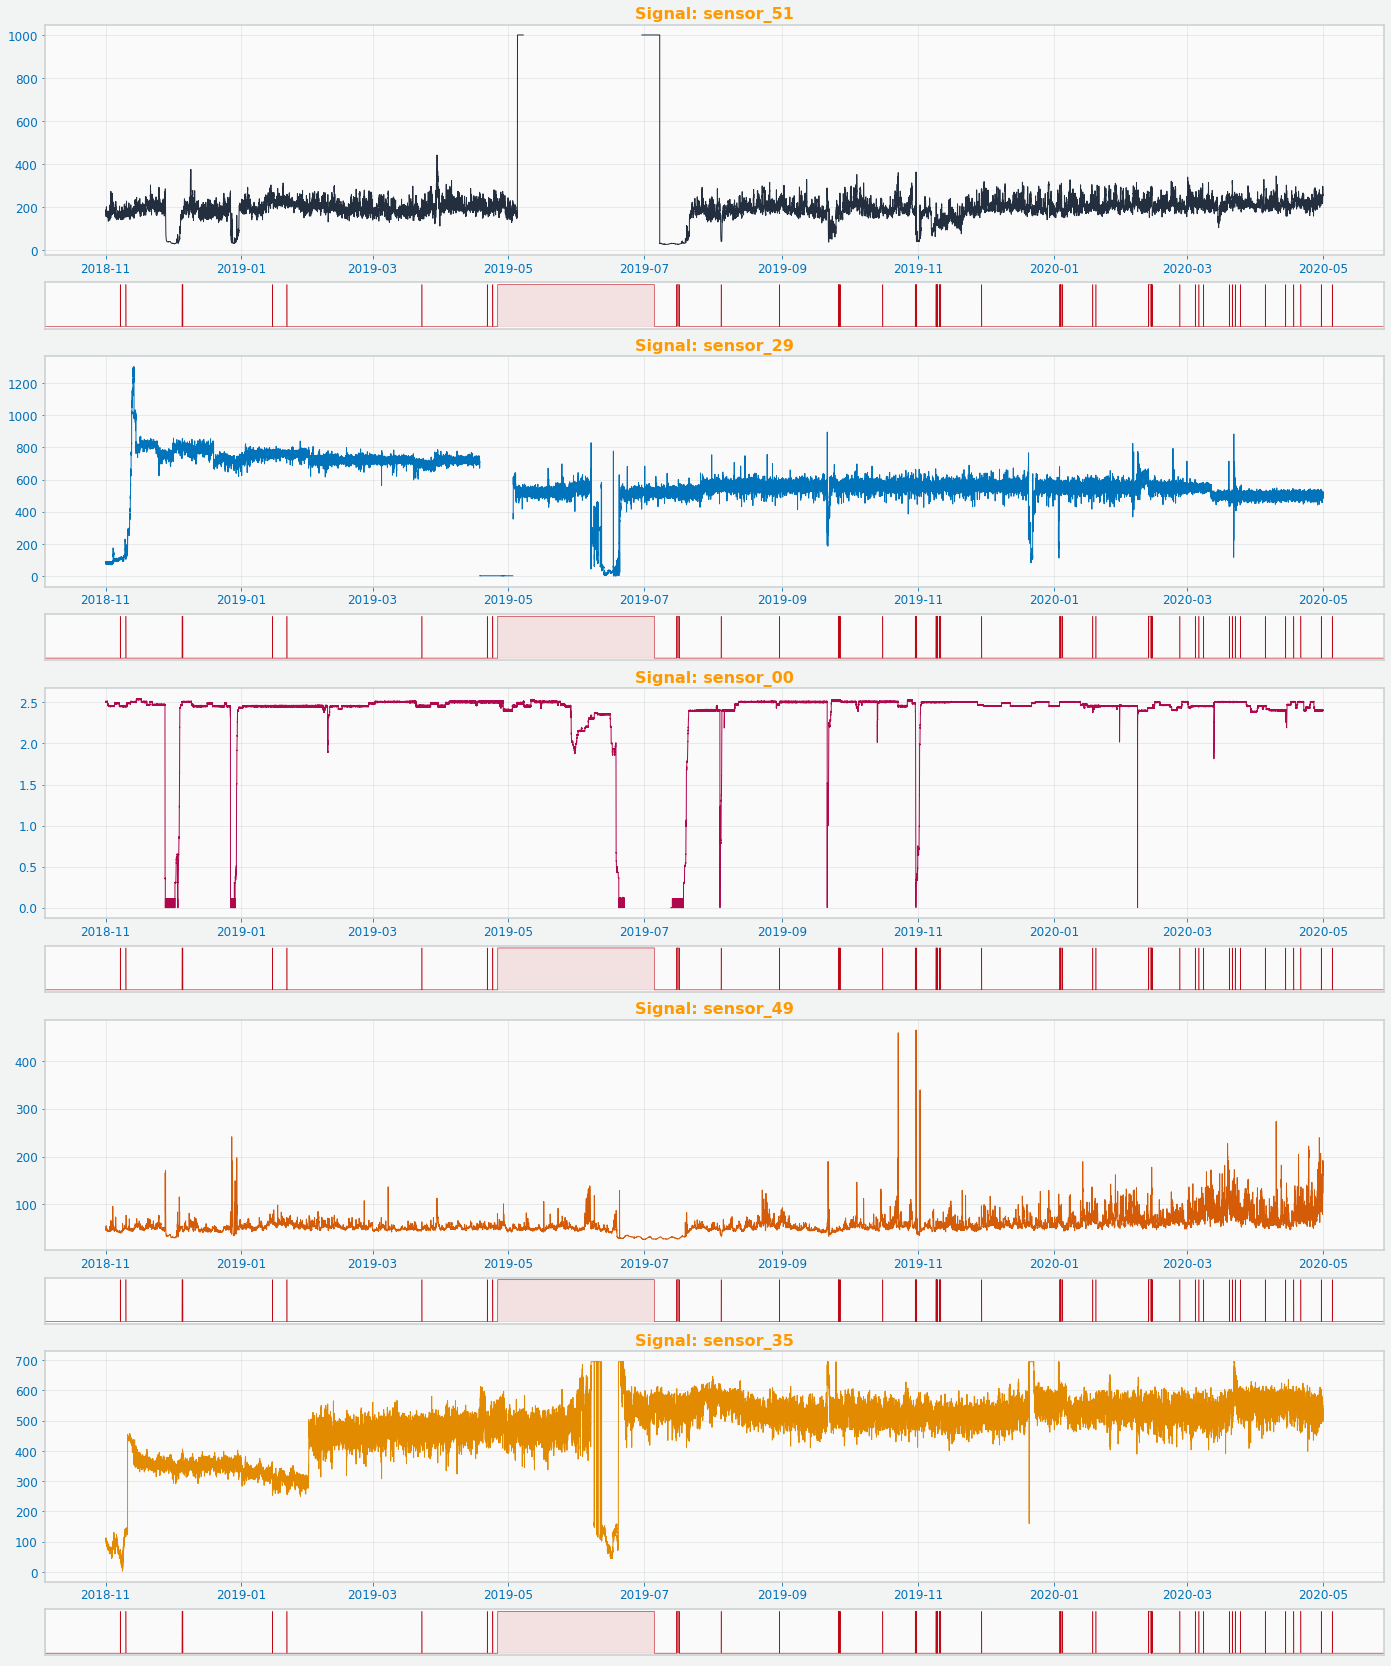

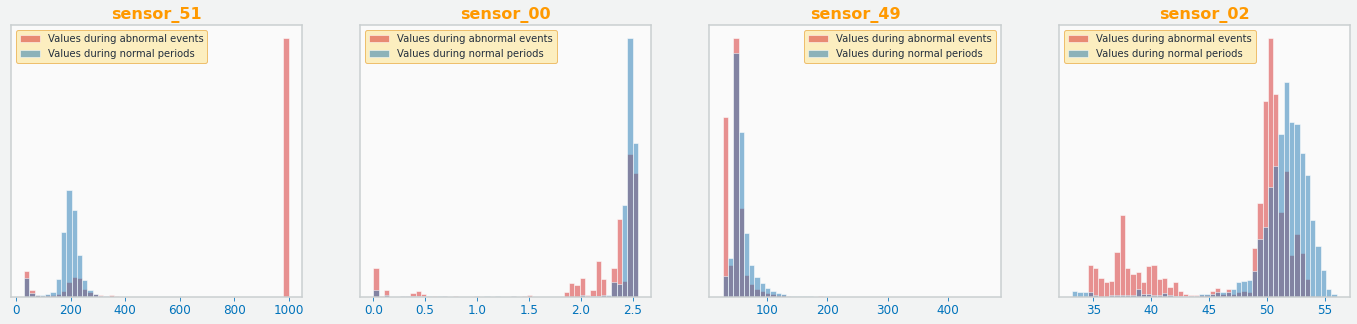

In [67]:
plot_start = evaluation_start
plot_end = evaluation_end

plot_detected_events('event_group', plot_start, plot_end, tags_list[0])
top_tags_list = plot_signal_importance_evolution('event_group', plot_start, plot_end, tags_list[0])
plot_top_signals_time_series('event_group', plot_start, plot_end, top_tags_list)
plot_histograms('event_group')

# **Conclusion and Call to Action**
---

Add label and retrain a model (will take a bit longer)

Adding label when training a model: [**SDK Documentation**](https://amazon-lookout-for-equipment-sdk.readthedocs.io/en/latest/generated/src.lookoutequipment.model.LookoutEquipmentModel.html#src.lookoutequipment.model.LookoutEquipmentModel)

### **Preparing label data** [Optional]

The following cell compresses the machine status column (one row per timestamp) into a shorter table where each row can be associated to a time range.

*This is an **optional step** as we will not be using this file during this workshop. However, you can leverage this file and train a new model with it as a homework (see the call to actions section at the end of this notebook for further details).*

In [13]:
range_df = pump_df[['machine_status']].copy()
range_df['BROKEN'] = False
range_df.loc[range_df['machine_status'] == 1.0, 'BROKEN'] = True

range_df['Next Status'] = range_df['BROKEN'].shift(-1)
range_df['Start Range'] = (range_df['BROKEN'] == False) & (range_df['Next Status'] == True)
range_df['End Range'] = (range_df['BROKEN'] == True) & (range_df['Next Status'] == False)
range_df.iloc[0,3] = range_df.iloc[0,1]
range_df = range_df[(range_df['Start Range'] == True) | (range_df['End Range'] == True)]

labels_df = pd.DataFrame(columns=['start', 'end'])
for index, row in range_df.iterrows():
    if row['Start Range']:
        start = index

    if row['End Range']:
        end = index
        labels_df = labels_df.append({
            'start': start + relativedelta(hours=-12),
            'end': end + relativedelta(hours=+12)
        }, ignore_index=True)
        
labels_df['start'] = pd.to_datetime(labels_df['start'])
labels_df['end'] = pd.to_datetime(labels_df['end'])
labels_df['start'] = labels_df['start'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')
labels_df['end'] = labels_df['end'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')

labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
labels_df.to_csv(labels_fname, header=None, index=None)
        
labels_df

,start,end
0,2018-05-30T01:30:00.000000,2018-06-03T08:15:00.000000
1,2018-06-24T14:25:00.000000,2018-07-06T09:40:00.000000
2,2018-11-27T04:25:00.000000,2018-12-02T17:50:00.000000
3,2018-12-26T14:25:00.000000,2018-12-29T16:55:00.000000
4,2019-06-19T01:55:00.000000,2019-07-19T05:10:00.000000
5,2019-08-03T12:50:00.000000,2019-08-04T16:20:00.000000
6,2019-10-30T09:55:00.000000,2019-10-31T16:15:00.000000
